### "Нахождение и сегментация кожных заболеваний на изображениях"
##### Часть 1. Подготовка данных для изучения проблемы.

In [1]:
!apt install unrar
!pip install gdown -q openpyxl
!gdown 'https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7' -O PH2Dataset.rar
!mkdir dataset
!unrar x PH2Dataset.rar dataset
!rm PH2Dataset.rar




The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 113 kB of archives.
After this operation, 406 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 unrar amd64 1:5.6.6-2build1 [113 kB]
Fetched 113 kB in 0s (545 kB/s)

78Selecting previously unselected package unrar.
(Reading database ... 108264 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a5.6.6-2build1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking unrar (1:5.6.6-2build1) ...
7Progress: [ 40%] [#######################...................................] 8Setting up unrar (1:5.6.6-2build1) ...
7Progress: [ 60%] [##################################........................] 8update-alternatives: using /usr/bin/unrar-nonfree to pro

In [2]:
import pandas as pd
import cv2
import os
import torch
import tqdm
import random
import torchvision
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import torchvision.transforms as trf
import torchvision.transforms.functional as fn

sns.set_style('whitegrid')
sns.set_theme('paper')

# Установим число-константу для всех генераторов (псевдо) случайных чисел
seed = random.randint(1, 100)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
# Некоторые константы для работы блокнота
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs_count = 30
bce_eps  = 1e-44
iou_eps  = 1e-8
im_shape = (256, 256)
pref_batch_size = 32
split_percentage = 0.15

In [4]:
# Имлпементация датасета PH2 для сегментации. Важно сделать: подзгрузить классы для картинок из таблицы
class PH2SegmentationDataset(torch.utils.data.Dataset):

    _trf_x = trf.Compose([
        trf.Resize(im_shape, antialias = True),
        trf.ToTensor(),
    ])

    _trf_y = trf.Compose([
        trf.Resize(im_shape),
        trf.ToTensor(),
    ])

    def __init__(self, path = './dataset', dev = 'cpu'):
        self.dev = dev
        self.base_path = f"{path}/PH2Dataset"

        # каждый IMD_N - это папка, которая содержит как базовое изображение, так и сегментированное
        files = os.listdir(self.base_path + '/PH2 Dataset images/')
        self.im_paths = sorted(list(files), key = lambda x: int(x[3:]))

        # загрузим таблицу для определения лэйблов
        ph2_df = pd.read_excel(self.base_path + '/PH2_dataset.xlsx').drop(index = range(11))
        ph2_df.columns = ph2_df.iloc[0].str.replace('\n', '')
        self.ph2_df = ph2_df[1:].sort_values(by = ['Image Name'])

    def __getitem__(self, idx):
        assert idx < len(self), f'oob attempt: dataset contains {len(self)} records'

        # получим данные из таблицы
        disease_chars = ds.ph2_df.iloc[idx, [0, 2, 3, 4]].dropna()

        # загрузим изображения
        diagnosis = disease_chars.index[-1]
        curr_image_name = disease_chars['Image Name']
        curr_path = f"{self.base_path}/PH2 Dataset images/{curr_image_name}"


        X_image = Image.open(f"{curr_path}/{curr_image_name}_Dermoscopic_Image/{curr_image_name}.bmp")
        Y_image = Image.open(f"{curr_path}/{curr_image_name}_lesion/{curr_image_name}_lesion.bmp")

        return self._trf_x(X_image), self._trf_y(Y_image), diagnosis

    def __len__(self):
        return len(self.im_paths)

ds = PH2SegmentationDataset(dev = dev)
#dl = torch.utils.data.DataLoader(ds, batch_size = pref_batch_size, shuffle = True)

ds_len = len(ds)
test_size = round(ds_len * split_percentage)

train, test = torch.utils.data.random_split(
    ds, (ds_len - test_size, test_size)
)

print(f'X_train_size = {len(train)} | X_test_size = {len(test)}')
train_dl = torch.utils.data.DataLoader(train, batch_size = pref_batch_size, shuffle = True)
test_dl  = torch.utils.data.DataLoader(test, batch_size = pref_batch_size)

X_train_size = 170 | X_test_size = 30


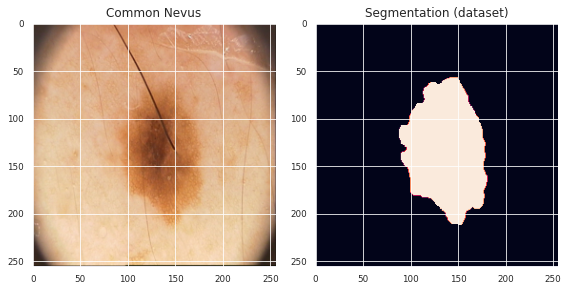

In [5]:
# Небольшая функция для визуализации
def plot_one_case(X, Y, diagnosis = '(No diagnosis)', Y_pred = None):
    X = X.cpu().permute(1, 2, 0)
    Y = Y.cpu().permute(1, 2, 0)

    cnt = 2 if Y_pred is None else 3

    fig, axs = plt.subplots(1, cnt, figsize = (8, 4))

    axs[0].set_title(diagnosis, size = 12)
    axs[1].set_title('Segmentation (dataset)', size = 12)

    axs[0].imshow(X)
    axs[1].imshow(Y)
    if Y_pred is not None:
        if isinstance(Y_pred, np.ndarray):
            axs[2].imshow(Y_pred.transpose(1, 2, 0))
        else:
            axs[2].imshow(Y_pred.cpu().permute(1, 2, 0).detach())
        axs[2].set_title('Segmentation (prediction)', size = 12)
    plt.tight_layout()

def apply_mask(img, mask):
    return cv2.bitwise_and(img, img, mask)

# покажем одно изображение из выборки данных
X, Y, diag = ds[np.random.randint(ds_len)]
plot_one_case(X, Y, diag)

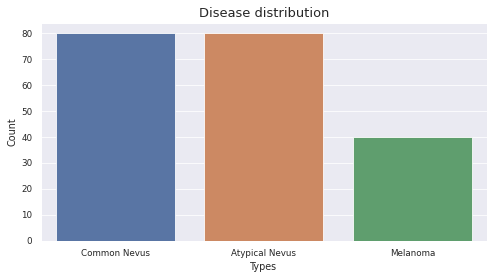

In [6]:
# Анализ данных (балансировка по классам)
labels = ['Common Nevus', 'Atypical Nevus', 'Melanoma']
values = list(ds.ph2_df[labels].count().values)

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
sns.barplot(x = labels, y = values, ax = ax)
ax.set_title('Disease distribution', size = 13)
ax.set_xlabel('Types')
ax.set_ylabel('Count')
plt.show()

Таким образом, класс melanoma наблюдается в два раза реже, чем остальные. Такая небольшая разница не должна сильно повлиять на процесс обучения нейросети. Для улучшения качества можно добавить class_weights (но это необязательно)

##### Часть 2. Имлпементация модели UNet для сегментации кожных заболеваний

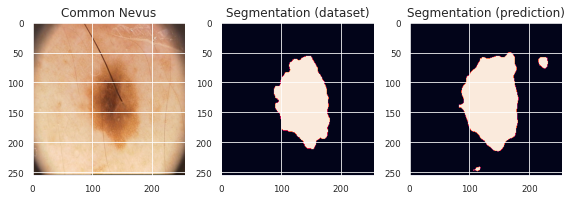

In [7]:
# вход (in_channels, X, Y) | выход (out_channels, (X - 4)/2, (Y - 4)/2)
class UNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, up = False):
        super(UNetBlock, self).__init__()

        padding = {'padding': 1}
        self.up = up
        layer_name = 'dec' if up else 'enc'


        self.conv_layer = nn.Sequential(OrderedDict([
            (f'{layer_name}_c1', nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, **padding)),
            (f'{layer_name}_bn1', nn.BatchNorm2d(out_channels)),
            (f'{layer_name}_a1', nn.ReLU()),
            (f'{layer_name}_c2', nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, **padding)),
            (f'{layer_name}_bn1', nn.BatchNorm2d(out_channels)),
            (f'{layer_name}_a2', nn.ReLU()),
        ]))
        self.l0 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2) if up else nn.MaxPool2d(kernel_size = 2)

    def forward(self, X, r_X = None):
        if self.up:
            ups_out = self.l0(X)
            crop_to_shape = ups_out.shape[2:]
            r_X = torchvision.transforms.CenterCrop(crop_to_shape)(r_X)

            ups_out = torch.cat([ups_out, r_X], axis = 1)

            return self.conv_layer(ups_out)
        else:
            out_conv = self.conv_layer(X)
            out_pooling = self.l0(out_conv)
            return out_pooling, out_conv

class SkinDiseaseSGv1(torch.nn.Module):
    def __init__(self, in_channels = 3):
        super(SkinDiseaseSGv1, self).__init__()

        self.enc_l0 = UNetBlock(3, 64)
        self.enc_l1 = UNetBlock(64, 128)
        self.enc_l2 = UNetBlock(128, 256)
        self.enc_l3 = UNetBlock(256, 512)

        self.bn = nn.Sequential(OrderedDict([
            ('bn_c1', nn.Conv2d(512, 1024, kernel_size = 3, stride = 1, padding = 1)),
            ('enc_bn1', nn.BatchNorm2d(1024)),
            ('bn_a1', nn.ReLU()),
            ('bn_c2', nn.Conv2d(1024, 1024, kernel_size = 3, stride = 1, padding = 1)),
            ('enc_bn1', nn.BatchNorm2d(1024)),
            ('bn_a2', nn.ReLU()),
        ]))

        self.dec_l0 = UNetBlock(1024, 512, up = True)
        self.dec_l1 = UNetBlock(512, 256, up = True)
        self.dec_l2 = UNetBlock(256, 128, up = True)
        self.dec_l3 = UNetBlock(128, 64, up = True)

        self.clf = nn.Sequential(OrderedDict([
            ('oc1', nn.Conv2d(64, 1, kernel_size = 1, stride = 1)),
#           ('oa1', nn.Sigmoid())
        ]))


    def forward(self, X):

        # encoding
        enc_l0_out, X_r0 = self.enc_l0(X)
        enc_l1_out, X_r1 = self.enc_l1(enc_l0_out)
        enc_l2_out, X_r2 = self.enc_l2(enc_l1_out)
        enc_l3_out, X_r3 = self.enc_l3(enc_l2_out)

        # bottleneck
        bn_out = self.bn(enc_l3_out)

        # decoding
        dec_l0_out = self.dec_l0(bn_out, X_r3)
        dec_l1_out = self.dec_l1(dec_l0_out, X_r2)
        dec_l2_out = self.dec_l2(dec_l1_out, X_r1)
        dec_l3_out = self.dec_l3(dec_l2_out, X_r0)

        return self.clf(dec_l3_out)

lr_model = SkinDiseaseSGv1()

# Загрузим веса. Модель была обучена на сервере google colab: 30 эпох (optim adam)
lr_model.load_state_dict(torch.load('../input/unet-melanoma-weights/segmentator.pt', map_location = torch.device('cpu')))
lr_model.to(dev)

Y_pred = lr_model(X.unsqueeze(0).to(dev))[0]
plot_one_case(X, Y, diag, torch.round(Y_pred.sigmoid()))

##### Обучение модели (расскоментировать при необходимости)

In [8]:
# x_batch, y_batch, diag_batch = next(iter(train_dl))
# y_preds = lr_model(x_batch.to(dev))
# y_batch = y_batch.to(dev)
#
# # объявим метрики и функцию ошибки для обучения нашей сети
# # out = intersect(y_preds, y_labels) / union(y_preds, y_labels)
# def IoU_score(y_preds, y_labels):
#     out = y_preds.int()
#     labels = y_labels.int()
#
#     i = (out & labels).float().sum((1, 2))
#     u = (out | labels).float().sum((1, 2))
#     iou = (i + iou_eps) / (u + iou_eps)
#
#     return iou.mean()
#
# def bce_with_logits(y_preds, y_batch):
#     y_preds = torch.sigmoid(y_preds).clamp(bce_eps, 1 - bce_eps)
#     bce_loss = -1 * (y_batch * torch.log(y_preds) + (1 - y_batch) * torch.log(1 - y_preds))
#     return bce_loss.mean()
#
# def evaluate_metrics(y_preds, y_actual, tbar = None):
#     show_function = print
#     if tbar is not None:
#         show_function = tbar.set_description
#
#     iou_score = IoU_score(y_preds, y_actual)
#     show_function(f'IoU score: {iou_score:2f}')
#
# loss = bce_with_logits(y_preds, y_batch)
# iou_score = IoU_score(y_preds, y_batch)
# print(f'Initial score: {iou_score} | initial loss: {loss}')

In [9]:
# Обучение модели

# optim = torch.optim.Adam(lr_model.parameters(), lr = 1e-4)
#
# t_bar = tqdm.tqdm(range(epochs_count))
# for epoch in t_bar:
#     losses = []
#     lr_model.train()
#     for x_batch, y_batch, _ in train_dl:
#         x_batch = x_batch.to('cuda')
#         y_batch = y_batch.to('cuda')
#
#         y_preds = lr_model(x_batch)
#         evaluate_metrics(y_preds, y_batch, t_bar, 'train')
#
#         loss_value = bce_with_logits(y_preds, y_batch)
#         losses.append(loss_value.cpu().detach())
#
#         optim.zero_grad()
#         loss_value.backward()
#         optim.step()
#
#     print(f'\nEpoch {epoch}: train_loss: {np.mean(losses)}')
#
#     # test:
#     test_losses = []
#     lr_model.eval()
#     with torch.inference_mode():
#         for x_batch, y_batch, _ in test_dl:
#             x_batch = x_batch.to('cuda')
#             y_batch = y_batch.to('cuda')
#
#             y_preds = lr_model(x_batch)
#             evaluate_metrics(y_preds, y_batch, t_bar, 'test')
#             loss_value = bce_with_logits(y_preds, y_batch)
#             test_losses.append(loss_value.cpu())
#     print(f'\t-- with test_loss: {np.mean(test_losses)}')